In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
%cd /content/drive/MyDrive/PFE/Model/Horse Gait Recognition

/content/drive/MyDrive/PFE/Model/AD-and-DLB-Classifier-master


In [ ]:
import pickle

import torch
import math
import numpy as np
import argparse
import os
import torch.nn as nn


# Define directory path for your data
data_dir = r"/content/drive/MyDrive/PFE/Model/Horse_Gait_Recognition/Data/Extracted/xsub"

# Define filenames for training and testing data (assuming .npy format)
file_train = 'train_data_joint_pad.npy'
file_test = 'val_data_joint_pad.npy'

print('loading data')
X_train = np.load(os.path.join(data_dir,file_train),  allow_pickle=True)
X_test = np.load(os.path.join(data_dir,file_test), allow_pickle=True)
y_train = np.load(os.path.join(data_dir,'train_labels_pad.pkl'), allow_pickle=True)
y_test = np.load(os.path.join(data_dir,'val_labels_pad.pkl'), allow_pickle=True)

y_train = y_train[1]

y_test = y_test[1]


X_train = X_train.transpose(0, 2 ,3 , 1)
print(X_train.shape)
X_test= X_test.transpose(0, 2 ,3 , 1)
print(X_test.shape)

def load_data_labels(data_dir, set_name):

    with open(os.path.join(data_dir, f'{set_name}_labels_pad.pkl'), 'rb') as f:
        labels = pickle.load(f)
    return  labels

# Example usage
y_train = load_data_labels(data_dir, 'train')
y_test = load_data_labels(data_dir, 'val')

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


loading data
(137, 50, 28, 2)
(34, 50, 28, 2)
(137, 50, 28, 2)
(34, 50, 28, 2)
(137,)
(34,)


In [ ]:
import numpy as np
import pandas as pd

def calculate_pattern_regularity(left_hoof, right_hoof):
    diff = left_hoof - right_hoof
    return np.std(diff)

def calculate_left_right_correlation(left_hoof, right_hoof):
    return np.corrcoef(left_hoof, right_hoof)[0, 1]

def calculate_reference_length(sequence):
    withers_position = sequence[:, 13, :]
    poll_position = sequence[:, 2, :]
    distances = np.sqrt(np.sum((withers_position - poll_position)**2, axis=1))
    return np.mean(distances)

def calculate_vertical_range(sequence, hoof_index):
    reference_length = calculate_reference_length(sequence)
    hoof_position = sequence[:, hoof_index, 1]  # Vertical position
    vertical_range = np.max(hoof_position) - np.min(hoof_position)
    normalized_vertical_range = vertical_range / reference_length
    return normalized_vertical_range

def extract_features(sequence):
    LEFT_FRONT_HOOF, RIGHT_FRONT_HOOF = 12, 8
    LEFT_HIND_HOOF, RIGHT_HIND_HOOF = 23, 19

    left_front = sequence[:, LEFT_FRONT_HOOF, 1]
    right_front = sequence[:, RIGHT_FRONT_HOOF, 1]
    left_hind = sequence[:, LEFT_HIND_HOOF, 1]
    right_hind = sequence[:, RIGHT_HIND_HOOF, 1]

    features = {
        'front_pattern_regularity': calculate_pattern_regularity(left_front, right_front),
        'hind_pattern_regularity': calculate_pattern_regularity(left_hind, right_hind),
        'front_left_right_correlation': calculate_left_right_correlation(left_front, right_front),
        'hind_left_right_correlation': calculate_left_right_correlation(left_hind, right_hind),
    }

    for hoof, name in zip([LEFT_FRONT_HOOF, RIGHT_FRONT_HOOF, LEFT_HIND_HOOF, RIGHT_HIND_HOOF],
                          ['LF', 'RF', 'LH', 'RH']):
        range_value = calculate_vertical_range(sequence, hoof)
        features[f'{name}_vertical_range'] = range_value
        features[f'{name}_skewness'] = pd.Series(sequence[:, hoof, 1]).skew()
        features[f'{name}_kurtosis'] = pd.Series(sequence[:, hoof, 1]).kurtosis()

    return features

def process_dataset(X_train, y_train):
    all_features = []

    for idx, (sequence, label) in enumerate(zip(X_train, y_train)):
        features = extract_features(sequence)
        features['sequence_id'] = idx
        features['label'] = label
        all_features.append(features)

    return pd.DataFrame(all_features)

 # X_train and y_train are your input data
df = process_dataset(X_train, y_train)

# Save to CSV
df.to_csv('horse_gait_16_train.csv', index=False)

In [ ]:
df_test = process_dataset(X_test, y_test)
df_test.to_csv('horse_gait_16_test.csv', index=False)

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


# Prepare the data for the classifier
df_train = pd.read_csv('horse_gait_16_train.csv')
X_train = df_train.drop(['sequence_id', 'label'], axis=1)
y_train = df_train['label']
X_test = df_test.drop(['sequence_id', 'label'], axis=1)
y_test = df_test['label']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test_scaled)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# Save the model and scaler (optional)
import joblib
joblib.dump(rf_classifier, 'random_forest_model.joblib')
joblib.dump(scaler, 'scaler.joblib')

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       0.91      0.83      0.87        12
           2       1.00      1.00      1.00        10

    accuracy                           0.91        34
   macro avg       0.92      0.92      0.92        34
weighted avg       0.91      0.91      0.91        34


Confusion Matrix:
[[11  1  0]
 [ 2 10  0]
 [ 0  0 10]]

Feature Importance:
                         feature  importance
2   front_left_right_correlation    0.144554
0       front_pattern_regularity    0.101694
1        hind_pattern_regularity    0.096501
8                    RF_skewness    0.085383
10             LH_vertical_range    0.075031
9                    RF_kurtosis    0.064955
7              RF_vertical_range    0.064254
4              LF_vertical_range    0.060297
6                    LF_kurtosis    0.056694
5                    LF_skewness    0.053546
14                   RH_

['scaler.joblib']

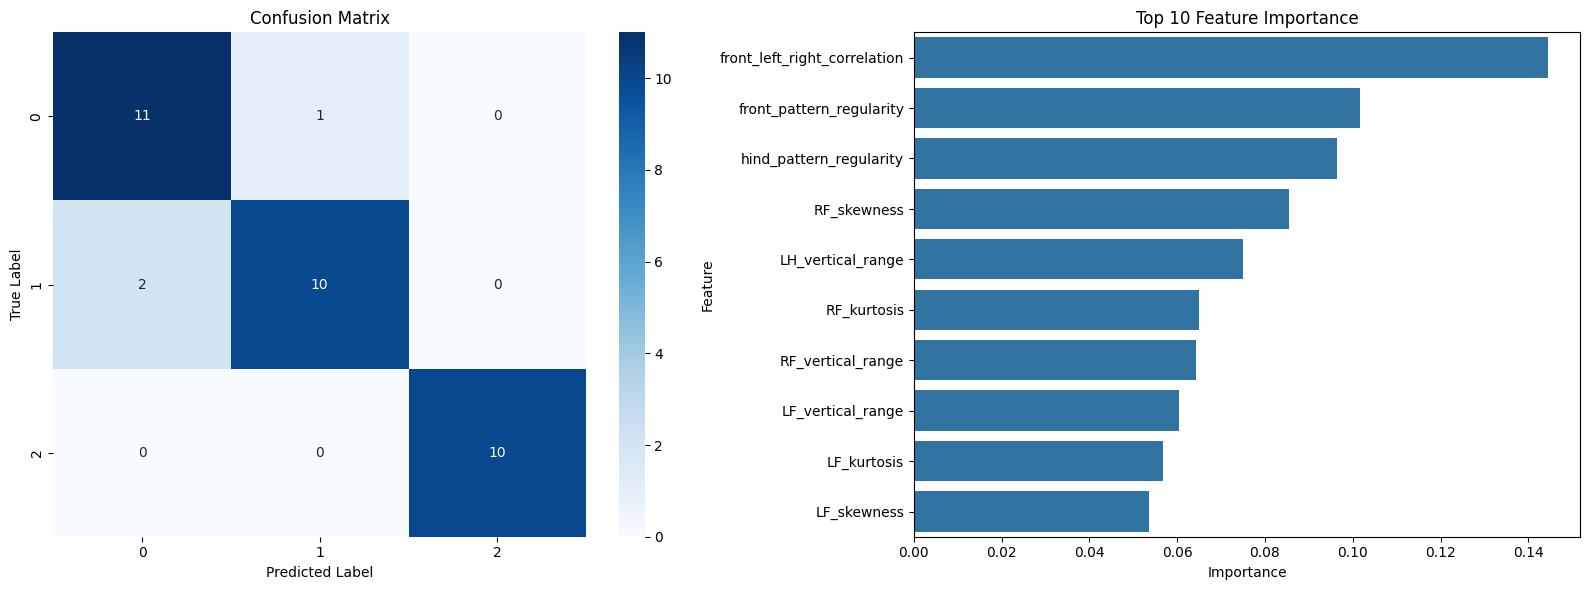


Feature Importance:
                         feature  importance
2   front_left_right_correlation    0.144554
0       front_pattern_regularity    0.101694
1        hind_pattern_regularity    0.096501
8                    RF_skewness    0.085383
10             LH_vertical_range    0.075031
9                    RF_kurtosis    0.064955
7              RF_vertical_range    0.064254
4              LF_vertical_range    0.060297
6                    LF_kurtosis    0.056694
5                    LF_skewness    0.053546
14                   RH_skewness    0.047602
3    hind_left_right_correlation    0.039098
11                   LH_skewness    0.030942
13             RH_vertical_range    0.030596
15                   RH_kurtosis    0.026169
12                   LH_kurtosis    0.022683


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Set up the matplotlib figure
plt.figure(figsize=(16, 6))

# 1. Confusion Matrix Visualization
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# 2. Feature Importance Visualization
plt.subplot(1, 2, 2)
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')

plt.tight_layout()
plt.savefig('model_evaluation_plots.png', dpi=300, bbox_inches='tight')
plt.show()

# Print feature importance
print("\nFeature Importance:")
print(feature_importance)

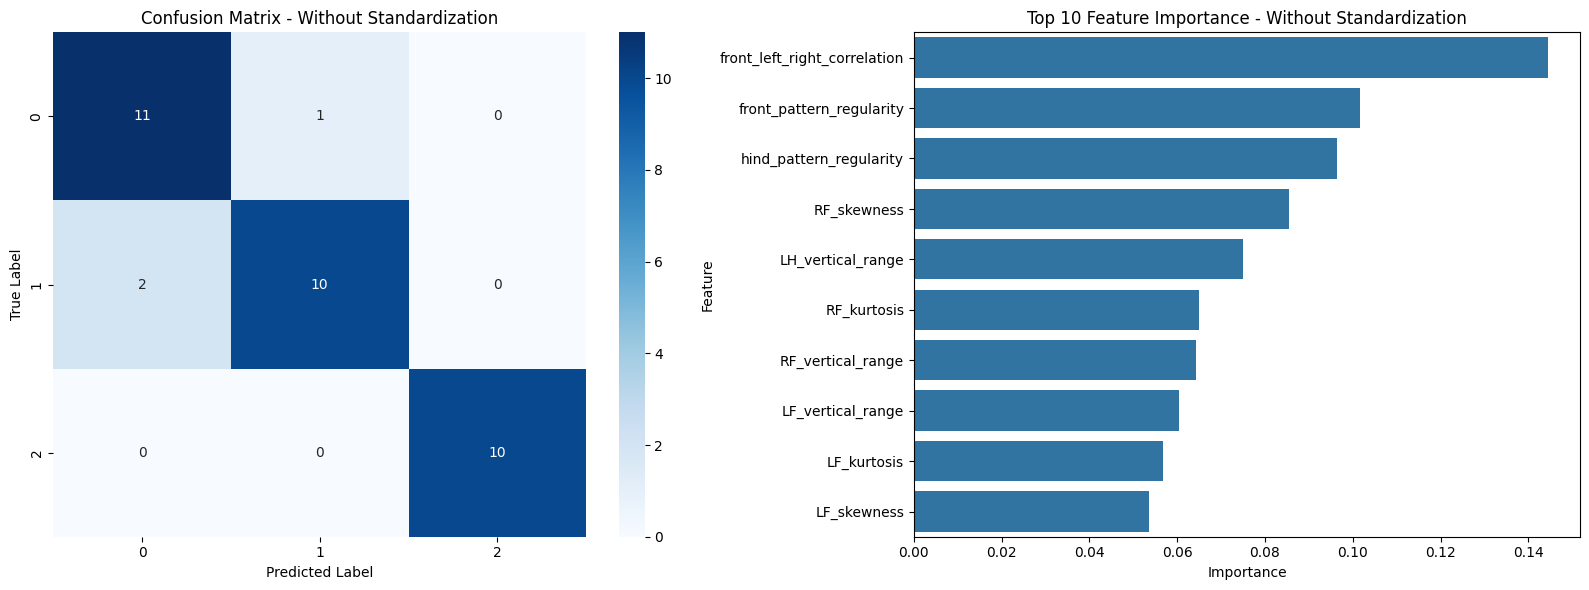

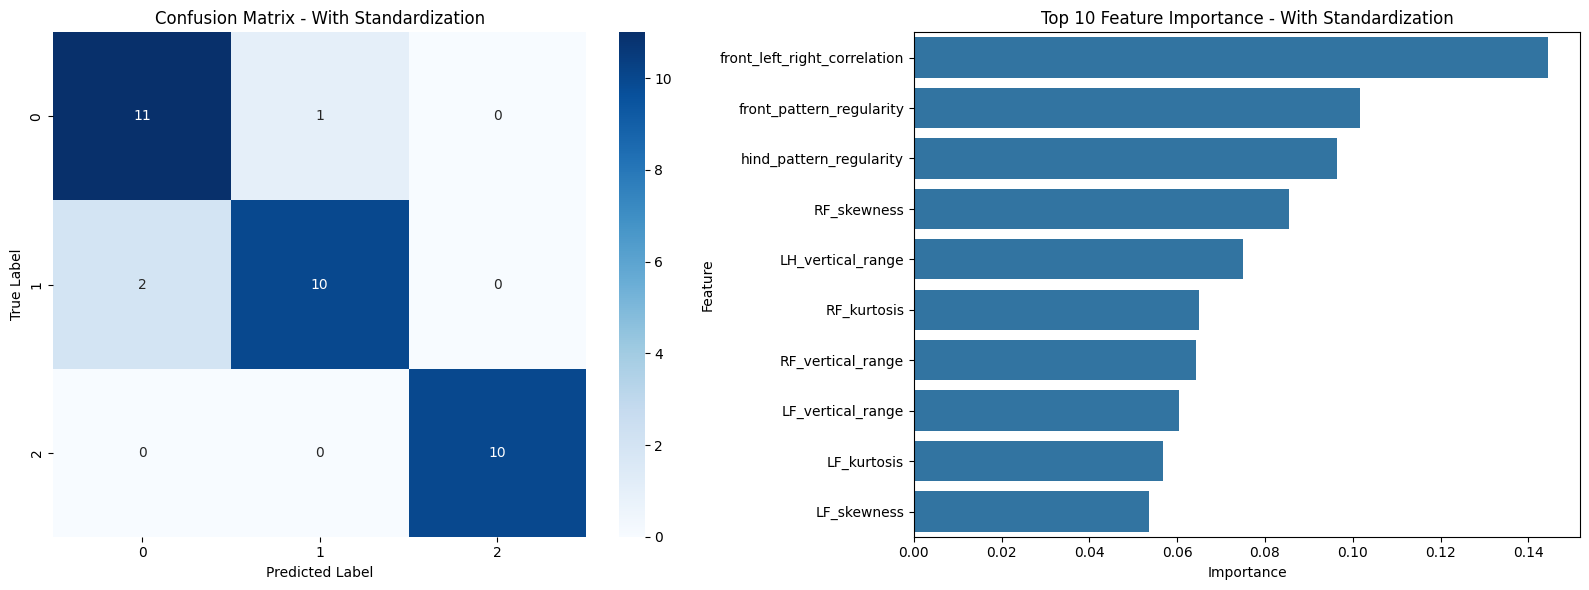

Classification Report - Without Standardization:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       0.91      0.83      0.87        12
           2       1.00      1.00      1.00        10

    accuracy                           0.91        34
   macro avg       0.92      0.92      0.92        34
weighted avg       0.91      0.91      0.91        34


Classification Report - With Standardization:
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        12
           1       0.91      0.83      0.87        12
           2       1.00      1.00      1.00        10

    accuracy                           0.91        34
   macro avg       0.92      0.92      0.92        34
weighted avg       0.91      0.91      0.91        34


Top 5 Features - Without Standardization:
                         feature  importance
2   front_left_right_correlation    0.144554
0       f

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

#Comparing with and without standardization random forest classifier

# Function to train, predict and evaluate
def train_evaluate_rf(X_train, X_test, y_train, y_test, standardize=False):
    if standardize:
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        X_train_scaled = X_train
        X_test_scaled = X_test

    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(X_train_scaled, y_train)
    y_pred = rf_classifier.predict(X_test_scaled)

    return rf_classifier, y_pred

# Run without standardization
rf_no_scale, y_pred_no_scale = train_evaluate_rf(X_train, X_test, y_train, y_test, standardize=False)

# Run with standardization
rf_with_scale, y_pred_with_scale = train_evaluate_rf(X_train, X_test, y_train, y_test, standardize=True)

# Function to plot results
def plot_results(y_true, y_pred, feature_importance, title):
    plt.figure(figsize=(16, 6))

    # Confusion Matrix
    plt.subplot(1, 2, 1)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    # Feature Importance
    plt.subplot(1, 2, 2)
    feature_importance = feature_importance.sort_values('importance', ascending=False).head(10)
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title(f'Top 10 Feature Importance - {title}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')

    plt.tight_layout()
    plt.savefig(f'model_evaluation_{title}.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot results for non-standardized data
feature_importance_no_scale = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_no_scale.feature_importances_
})
plot_results(y_test, y_pred_no_scale, feature_importance_no_scale, "Without Standardization")

# Plot results for standardized data
feature_importance_with_scale = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_with_scale.feature_importances_
})
plot_results(y_test, y_pred_with_scale, feature_importance_with_scale, "With Standardization")

# Print classification reports
print("Classification Report - Without Standardization:")
print(classification_report(y_test, y_pred_no_scale))

print("\nClassification Report - With Standardization:")
print(classification_report(y_test, y_pred_with_scale))

# Compare feature importances
print("\nTop 5 Features - Without Standardization:")
print(feature_importance_no_scale.sort_values('importance', ascending=False).head())

print("\nTop 5 Features - With Standardization:")
print(feature_importance_with_scale.sort_values('importance', ascending=False).head())